# Accuracy Evaluation on the Celeba Dataset

**Note:** in case you would like to see the implementation of key functions used in research, see `encoder_keras_facenet.ipynb`, this file is used to get accuracies for the Celeba Dataset file. The key difference is that here we load everything by batches as we cannot store the whole dataset in one variable

Import packages:

In [94]:
# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow image preprocessing 
from tensorflow.keras.preprocessing import image as image_preprocessing
import tensorflow.keras.backend as tf_backend 
tf_backend.set_image_data_format('channels_last')

# Importing fetch_lfw_people dataset from the sklearn.datasets package
from sklearn.datasets import fetch_lfw_people

# Import all other needed packages
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import face_recognition
import glob
from PIL import Image

# Internal helper imports
from helpers import graphics as help_graph
from helpers import binary_converter as help_binary
from helpers import accuracy_calculator as help_calc
from helpers import shaper as help_shaper
from helpers import vector_extractor as help_extract
from helpers import segmenter as help_segmenter

%matplotlib inline

Load the dataset by batches

In [95]:
# Specifying path to the images
celeba_images_path = './Images/celeb_faces/img_align_celeba'
celeba_labels_path = './Images/celeb_faces/identity_CelebA.txt'

people_images, people_labels = [], []

# Loading txt file
with open(celeba_labels_path) as labels_file:
    labels_file_lines = labels_file.read().splitlines()

image_paths = [labels_file_line.split(" ")[0] for labels_file_line in labels_file_lines]
labels = [labels_file_line.split(" ")[1] for labels_file_line in labels_file_lines]

# Sorting array according to the labels
image_paths = [image_path for _, image_path in sorted(zip(labels, image_paths))]
labels.sort()

In [98]:
def get_segments(sorted_people_labels, threshold=30, must_equal=True, max_number_segments=50):
    bounds = []
    left_bound = 0
    for i in range(len(sorted_people_labels) - 1):
        if sorted_people_labels[i] != sorted_people_labels[i+1]:
            condition = (i - left_bound + 1 >= threshold) if not must_equal else (i - left_bound + 1 == threshold)  
            
            if condition:
                bounds.append([left_bound, i])
            left_bound = i+1
    
    return bounds[:min(max_number_segments, len(bounds))]
                      
segments = get_segments(labels, threshold=30, must_equal = True, max_number_segments=200)
print('Number of segments is', len(segments)) 

Number of segments is 200


In [99]:
def form_image_batches(image_paths, segments):
    image_batches = []
    
    for segment_id, segment in enumerate(segments):
        image_batch = []  
        
        for image_path_id in range(segment[0], segment[1] + 1):
            image = cv2.cvtColor(cv2.imread(celeba_images_path + '/' + image_paths[image_path_id]), cv2.COLOR_BGR2RGB)
            image_batch.append(image)
        image_batches.append(image_batch)
    
    print('Successfully loaded all segments')
    return image_batches

In [100]:
image_batches = form_image_batches(image_paths, segments)

Successfully loaded all segments


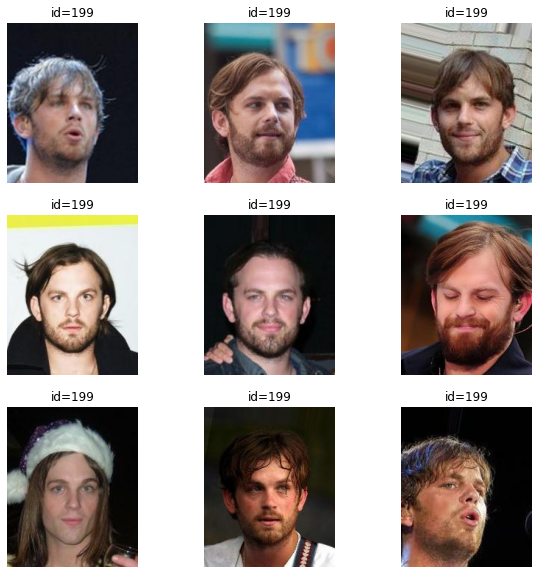

In [102]:
gallery_offset = 10 # Can be changed to "move" the gallery
gallery_width = 3 # Can be changed to resize gallery
person_id = 199

help_graph.display_images(
    image_batches[person_id][(gallery_offset):(gallery_width**2 + gallery_offset)], 
    np.full((gallery_width**2), person_id, dtype=int))

In [103]:
image_batches_np = np.array(image_batches)
print('Image batches shape is', image_batches_np.shape)

Image batches shape is (200, 30, 218, 178, 3)


In [104]:
model = keras.models.load_model('models/facenet_keras.h5', compile=False)

In [105]:
# Segmenting batches (OPTIONAL)
image_batches_segmented = help_segmenter.segment_batches(image_batches)

Trying to load batch #0...
Trying to load batch #1...
Trying to load batch #2...
Trying to load batch #3...
Trying to load batch #4...
Trying to load batch #5...
Trying to load batch #6...
Trying to load batch #7...
Trying to load batch #8...
Trying to load batch #9...
Trying to load batch #10...
Trying to load batch #11...
Trying to load batch #12...
Trying to load batch #13...
Trying to load batch #14...
Trying to load batch #15...
Trying to load batch #16...
Trying to load batch #17...
Trying to load batch #18...
Trying to load batch #19...
Trying to load batch #20...
Trying to load batch #21...
Trying to load batch #22...
Trying to load batch #23...
Trying to load batch #24...
Trying to load batch #25...
Trying to load batch #26...
Trying to load batch #27...
Trying to load batch #28...
Trying to load batch #29...
Trying to load batch #30...
Trying to load batch #31...
Trying to load batch #32...
Trying to load batch #33...
Trying to load batch #34...
Trying to load batch #35...
Tr

In [113]:
def normalize_batches_size(batches, new_size=28):
    new_batches = []
    for batch in batches:
        if(len(batch) < 28):
            continue
        
        new_batches.append(batch[:new_size])
    
    return new_batches

Normalized batches array shape (178, 26)


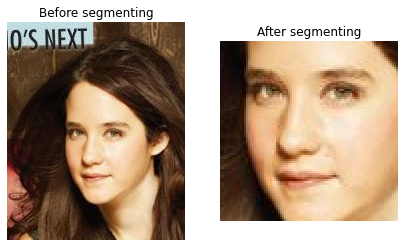

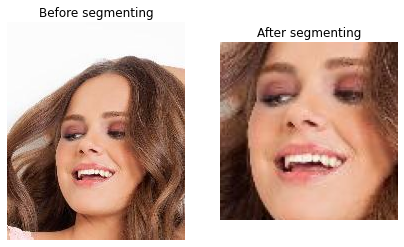

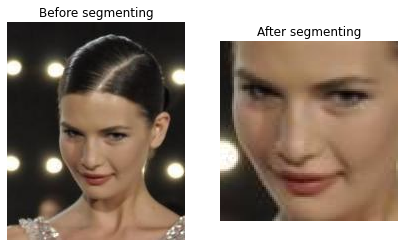

In [114]:
image_batches_segmented_np = normalize_batches_size(image_batches_segmented, new_size=26)
print('Normalized batches array shape', np.shape(image_batches_segmented_np))

help_graph.visualize_segmented(image_batches[4][3], image_batches_segmented_np[4][3], figure_size=7)
help_graph.visualize_segmented(image_batches[1][10], image_batches_segmented_np[1][10], figure_size=7)
help_graph.visualize_segmented(image_batches[2][20], image_batches_segmented_np[2][20], figure_size=7)

In [116]:
# Updating image_batches_numpy
image_batches_numpy = image_batches_segmented_np

In [117]:
# Getting array of feature vectors
feature_vectors = help_extract.extract_vectors_from_batches(image_batches_numpy, model=model)

Loading batch #0...
Successfully processed batch #0

Loading batch #1...
Successfully processed batch #1
Loading batch #2...
Successfully processed batch #2
Loading batch #3...
Successfully processed batch #3
Loading batch #4...
Successfully processed batch #4
Loading batch #5...
Successfully processed batch #5
Loading batch #6...
Successfully processed batch #6
Loading batch #7...
Successfully processed batch #7
Loading batch #8...
Successfully processed batch #8
Loading batch #9...
Successfully processed batch #9
Loading batch #10...
Successfully processed batch #10
Loading batch #11...
Successfully processed batch #11
Loading batch #12...
Successfully processed batch #12
Loading batch #13...
Successfully processed batch #13
Loading batch #14...
Successfully processed batch #14
Loading batch #15...
Successfully processed batch #15
Loading batch #16...
Successfully processed batch #16
Loading batch #17...
Successfully processed batch #17
Loading batch #18...
Successfully processed bat

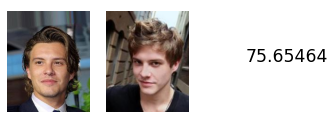

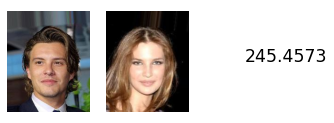

In [118]:
n1, i1, k1, j1 = 0, 0, 0, 6
n2, i2, k2, j2 = 0, 0, 2, 15


help_graph.distance_visualize(image_batches[n1][i1], 
                   image_batches[k1][j1], 
                   help_extract.feature_vectors_distance(feature_vectors[n1][i1], feature_vectors[k1][j1]))
help_graph.distance_visualize(image_batches[n2][i2], 
                   image_batches[k2][j2],
                   help_extract.feature_vectors_distance(feature_vectors[n2][i2], feature_vectors[k2][j2]))

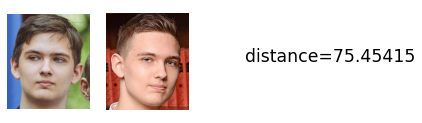

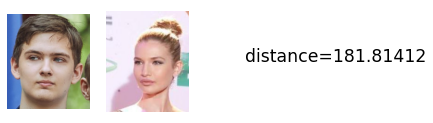

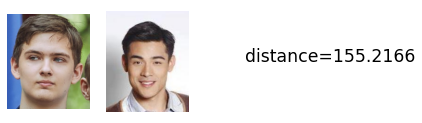

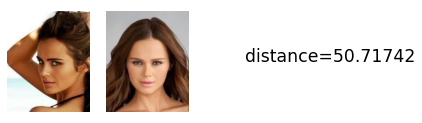

In [120]:
# Read images
person_1 = np.array(Image.open('Images/Dima1.png'))
person_2 = np.array(Image.open('Images/Dima2.png'))

# Visualization of all distances
help_graph.distance_visualize(person_1, person_2, help_extract.get_distance_between_images(person_1, person_2, model), 'distance')
help_graph.distance_visualize(person_1, image_batches[2][3], help_extract.get_distance_between_images(person_1, image_batches[2][3], model), 'distance')
help_graph.distance_visualize(person_1, image_batches[3][10], help_extract.get_distance_between_images(person_1, image_batches[3][10], model), 'distance')
help_graph.distance_visualize(image_batches[1][15], 
                   image_batches[1][20], 
                   help_extract.get_distance_between_images(image_batches[1][15], image_batches[1][20], model), 'distance')

In [121]:
# Forming a list of pairs
pairs = help_shaper.form_pairs_list((len(feature_vectors), help_shaper.get_minimal_batch_size(feature_vectors)))

In [122]:
# Getting arrays of threshold and accuracies
thresholds, accuracies = help_calc.threshold_accuracies(pairs, feature_vectors, lower_edge=40.0, upper_edge=300.0, step=0.1)

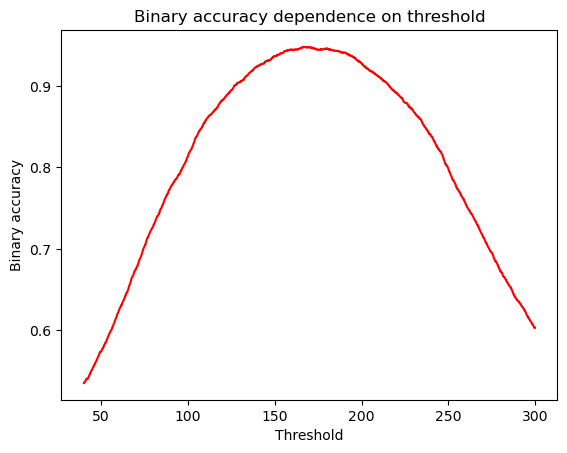

In [123]:
help_graph.draw_plot(thresholds, accuracies,
                     X_label='Threshold', Y_label='Binary accuracy', 
                     title='Binary accuracy dependence on threshold', color='red')

In [124]:
best_threshold = help_calc.get_best_threshold(pairs, feature_vectors, lower_edge=40.0, upper_edge=200.0, step=0.1)
print('Best threshold is', best_threshold)
print('Binary accuracy is', help_calc.calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=best_threshold))

Best threshold is 166.3000000000018
Binary accuracy is 0.9478487614080835


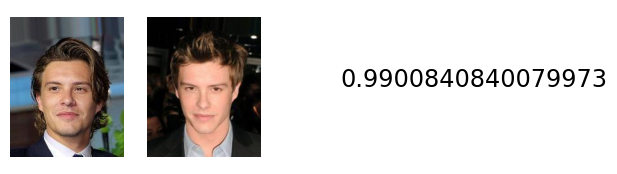

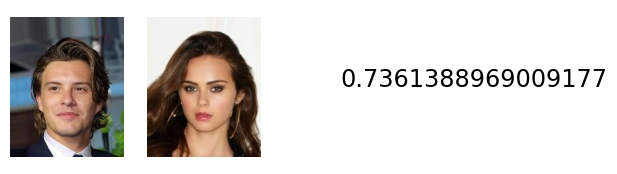

In [125]:
#Visualization of accuracy between images

help_graph.distance_visualize(image_batches[0][0], 
                   image_batches[0][1], 
                   help_calc.calculate_pair_accuracy(feature_vectors, 0, 0, 0, 1, threshold=best_threshold))
help_graph.distance_visualize(image_batches[0][0], 
                   image_batches[1][0], 
                   help_calc.calculate_pair_accuracy(feature_vectors, 0, 0, 1, 0, threshold=best_threshold))

In [126]:
# Getting accuracy
print('Total accuracy is', help_calc.calculate_pairs_accuracy(pairs, feature_vectors, threshold=best_threshold))
print('Total binary accuracy is', help_calc.calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=best_threshold))

Total accuracy is 0.7579557290446755
Total binary accuracy is 0.9478487614080835


In [127]:
# Forming the string batches from the feature vectors
string_batches = help_binary.form_string_batches(feature_vectors)

In [128]:
same_pairs, different_pairs = help_shaper.split_pairs(pairs)

print('Average similarity between same person', help_binary.get_average_similarity(string_batches, same_pairs))
print('Average similarity between different people', help_binary.get_average_similarity(string_batches, different_pairs))

Average similarity between same person 0.7365140156453716
Average similarity between different people 0.5172004019991309


# face_recognition Package

In [134]:
# Getting array of feature vectors
feature_vectors_facenet = help_extract.extract_vectors_from_batches_facenet(image_batches)

In [187]:
# Forming a list of pairs
pairs_facenet = help_shaper.form_pairs_list((len(feature_vectors_facenet), help_shaper.get_minimal_batch_size(feature_vectors_facenet)))

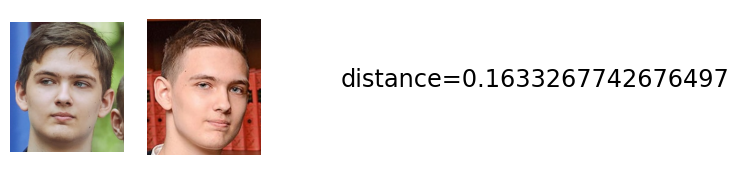

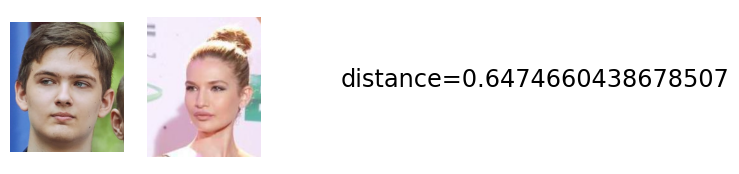

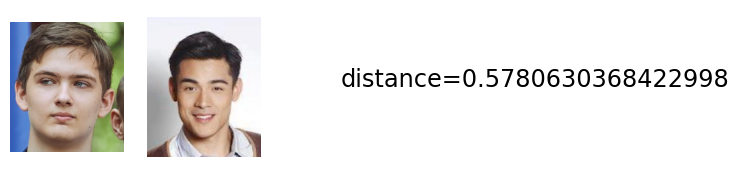

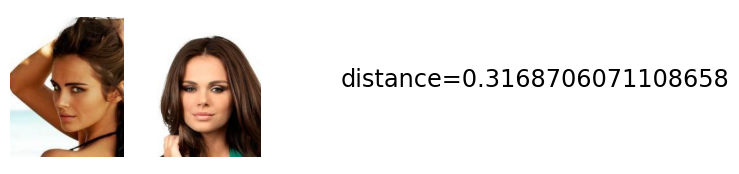

In [140]:
# Read images
person_1 = np.array(Image.open('Images/Dima1.png'))
person_2 = np.array(Image.open('Images/Dima2.png'))

# Visualization of all distances
help_graph.distance_visualize(person_1, person_2, 
                              help_extract.get_distance_between_image_face_recognition(person_1, person_2), 'distance')
help_graph.distance_visualize(person_1, image_batches[2][3], 
                              help_extract.get_distance_between_image_face_recognition(person_1, image_batches[2][3]), 'distance')
help_graph.distance_visualize(person_1, image_batches[3][10], 
                              help_extract.get_distance_between_image_face_recognition(person_1, image_batches[3][10]), 'distance')
help_graph.distance_visualize(image_batches[1][15], 
                   image_batches[1][29], 
                   help_extract.feature_vectors_distance(feature_vectors_facenet[1][15], feature_vectors_facenet[1][29]), 'distance')

In [188]:
# Getting arrays of threshold and accuracies
thresholds, accuracies = help_calc.threshold_accuracies(pairs_facenet, feature_vectors_facenet, 
                                                        lower_edge=0.0, upper_edge=1.0, step=0.01)

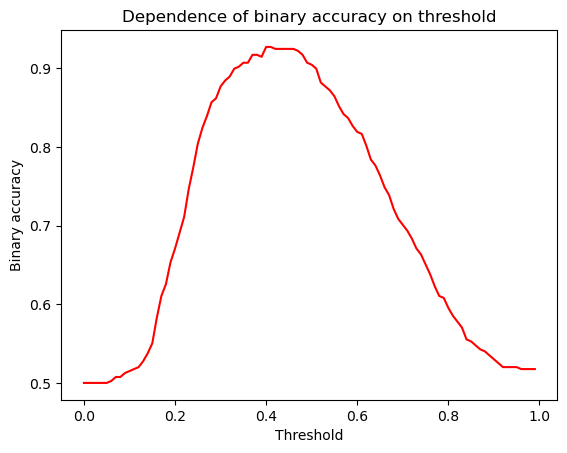

In [189]:
# Drawing a plot
help_graph.draw_plot(thresholds, accuracies, X_label='Threshold', Y_label='Binary accuracy', 
                     title='Dependence of binary accuracy on threshold', color='red')

In [193]:
best_threshold = help_calc.get_best_threshold(pairs_facenet, feature_vectors_facenet, lower_edge=0.0, upper_edge=1.0, step=0.001)
print('Best threshold is', best_threshold)
print('Binary accuracy is', help_calc.calculate_pairs_binary_accuracy(pairs_facenet, feature_vectors_facenet, threshold=best_threshold))

Best threshold is 0.402
Binary accuracy is 0.9321608040201005


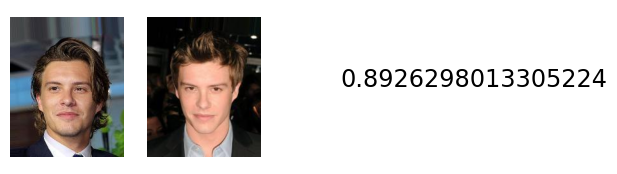

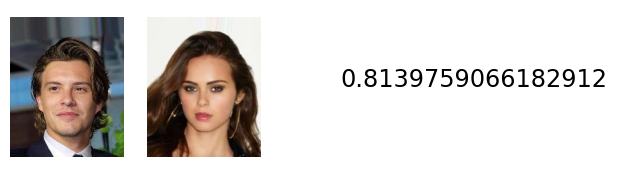

In [194]:
#Visualization of accuracy between images

help_graph.distance_visualize(image_batches[0][0], 
                   image_batches[0][1], 
                   help_calc.calculate_pair_accuracy(feature_vectors_facenet, 0, 0, 0, 1, threshold=best_threshold))
help_graph.distance_visualize(image_batches[0][0], 
                   image_batches[1][0], 
                   help_calc.calculate_pair_accuracy(feature_vectors_facenet, 0, 0, 1, 0, threshold=best_threshold))

In [196]:
accuracy = help_calc.calculate_pairs_accuracy([[0, 0, 0, 1], [0, 0, 1, 0]], feature_vectors_facenet, threshold=best_threshold)
print('Cumulative accuracy for two images above is', accuracy)

Cumulative accuracy for two images above is 0.8542086217015247


In [197]:
# Getting accuracy
print('Total accuracy is', help_calc.calculate_pairs_accuracy(pairs_facenet, feature_vectors_facenet, threshold=best_threshold))
print('Total binary accuracy is', help_calc.calculate_pairs_binary_accuracy(pairs_facenet, feature_vectors_facenet, threshold=best_threshold))

Total accuracy is 0.7472689273104807
Total binary accuracy is 0.9321608040201005


In [198]:
# Forming the string batches from the feature vectors
string_batches_facenet = help_binary.form_string_batches(feature_vectors_facenet)

In [199]:
same_pairs, different_pairs = help_shaper.split_pairs(pairs_facenet)

print('Average similarity between same person', help_binary.get_average_similarity(string_batches_facenet, same_pairs))
print('Average similarity between different people', help_binary.get_average_similarity(string_batches_facenet, different_pairs))

Average similarity between same person 0.8846184045226131
Average similarity between different people 0.8094770728643216
